In [ ]:
import pandas as pd
import numpy as np
import re

from time import time
!pip install python-levenshtein
from Levenshtein import setratio as R

# Baca Data
ide kedepannya:
1. tambah kolom **(dugaan) buyer** di data bank
2. buat df hasil left join data bank dan data cek
3. simpan df['sid', 'cid'] hasil left join

In [2]:
bank = pd.read_csv('bank_statement.csv')
bank.rename(inplace=True,
            columns={'stmt_id': 'sid',
                     'stmt_amount': 'amount',
                     'desc': 'desc'})
bank.tail()

,sid,amount,desc
239995,239996,45.63,RV WC XUH AQLIXA GIXYI WAX
239996,239997,63.30,TRANSFER RO MA/BA EYEKIA AT GXAZMIB * YELB ...
239997,239998,9.76,INSTANT TRANSFER PUZ JATITI WJAJIZAJ* TEDW ...
239998,239999,145.00,WUVIJA XAJVISA FISD* SURWISZ POYER * AKSURWISZ...
239999,240000,30.28,WEE BIAJ SUI * BCC QD-SHOPEE LV XALDZ TR...


In [3]:
cek = pd.read_csv('checkout.csv')
cek.rename(inplace=True,
            columns={'ckt_id': 'cid',
                     'ckt_amount': 'amount',
                     'buyer_name': 'buyer'})
cek.tail()

,cid,amount,buyer
239995,329026,15.00,VAQFILAPA JIPTI NORABI
239996,329027,70.39,JIQI CUWAIVAC FIBQI IFVACIW
239997,329030,35.08,MFAFHIYAB JIYVI MFAQMUTTIY
239998,329031,20.62,VAHID DUBRQAVIBA JH FOQL ANAD
239999,329032,16.77,HAGOUF GOJBAQ


# Cleaning Deskripsi

hilangkan simbol, whitespace, dan stopwords

In [4]:
%%time

# hilangkan kata yang mengandung simbol ditengahnya
# contoh: "LA/FA", "QD-SHOPEE", ...
bank['desc'] = bank['desc'].apply(lambda string: re.sub(r'[A-Z]+[^\w^\s]+[A-Z]+', '', string))

# hilangkan simbol-simbol dari deskripsi karena... ngga penting
# contoh: "*"
bank['desc'] = bank['desc'].apply(lambda string: re.sub(r'[^\w]', ' ', string))

# rapikan whitespace dari deskripsi karena... cuma biar enak dilihat aja (kurangi memori)
#contoh: "   ", "\t"
bank['desc'] = bank['desc'].apply(lambda string: ' '.join(string.split()))

CPU times: user 2.52 s, sys: 26.6 ms, total: 2.55 s
Wall time: 2.56 s


In [5]:
bank.tail()

,sid,amount,desc
239995,239996,45.63,RV WC XUH AQLIXA GIXYI WAX
239996,239997,63.30,TRANSFER RO EYEKIA AT GXAZMIB YELB RXA AFUNDSY...
239997,239998,9.76,INSTANT TRANSFER PUZ JATITI WJAJIZAJ TEDW HZA ...
239998,239999,145.00,WUVIJA XAJVISA FISD SURWISZ POYER AKSURWISZ POYER
239999,240000,30.28,WEE BIAJ SUI BCC LV XALDZ TRANSFER XBLV XALDZ TO


In [6]:
%%time

# coba untuk kumpulkan setiap word
sentences = ' '.join(bank['desc']).upper()
words = sentences.split()
print('len:', len(words))

len: 1644537
CPU times: user 128 ms, sys: 47 ms, total: 175 ms
Wall time: 175 ms


In [7]:
%%time

# coba hitung banyak munculnya word
counted = {}
for word in words:
    if word not in counted:
        counted[word] = 0
    counted[word] += 1
    
# gatau apakah ini efisien... ubah jadi dict list
temp = [[count, word] for word, count in counted.items()]

# lalu buat dataframe frekuensi(?) kata yang terurut turun
words = pd.DataFrame(sorted(temp, reverse=True), columns=['count', 'word'])

CPU times: user 3.88 s, sys: 32.2 ms, total: 3.91 s
Wall time: 3.92 s


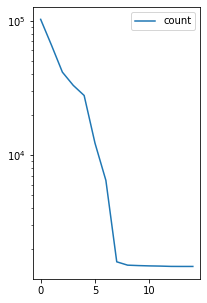

In [8]:
# coba buat grafiknya
words.iloc[:15].plot(logy=True, figsize=(3, 5));

In [9]:
# grafik yang menakjubkan... penasaran apa
# saja 50 kata paling sering muncul
print(words.iloc[:30]['word'].tolist())

['TRANSFER', 'TO', 'SHOPEE', 'INSTANT', 'A', 'TRANSFERTO', 'FUNDS', 'SAVINGS', 'Z', 'Y', 'X', 'G', 'H', 'S', 'K', 'W', 'Q', 'D', 'F', 'V', 'N', 'P', 'B', 'C', 'L', 'T', 'M', 'J', 'R', 'AM']


In [10]:
# seems that 10 kata pertama dapat kita anggap sebagai stopwords
stopwords = set(words.iloc[:10]['word'])

# malahan, sekalian aja kita masukan huruf A..Z sebagai stopwords 
stopwords.update(list('QWERTYUIOPASDFGHJKLZXCVBNM'))

In [11]:
# buang stopwords dari deskripsi
bank['desc'] = bank['desc'].apply(lambda string: ' '.join(set(string.split())-stopwords))

# Membuat Model
Levenhstein Set Ratio, mirip fuzzy search; dan sekitar 5-8 kali lebih cepat dari module `fuzzywuzzy`

In [12]:
def find(amount, desc):
    # simpan desc jadi list, untuk menghemat
    # waktu untuk ngitung LSR terbesar
    desc = desc.split()
    
    # ambil data buyer di cek dengan amount yang sama
    # dengan amount-nya bank. ngga tau apakah kode ini efisien
    P = [row[-1] for row in cek[cek['amount']==amount].values]    
    
    # cari orang dengan levenstein set ratio terbesar di P
    return max([R(desc, buyer.split()), buyer] for buyer in P)[1]

In [13]:
# untuk stmt_id = 1, ada data `amount` dan `desc` berikut
%time find(100, 'LEZC ZLLEZC YIWHI CGANBAWI BAW FUNDSHXA HXA')

CPU times: user 11.6 ms, sys: 9.99 ms, total: 21.6 ms
Wall time: 32.7 ms


'BAW CGANBAWI'

# Testing

In [14]:
%%time

bonk = bank.iloc[:2000].copy()
bonk['buyer'] = bonk.apply(lambda row: find(row[1], row[2]), axis=1)

CPU times: user 3.41 s, sys: 87.3 ms, total: 3.5 s
Wall time: 3.55 s


In [15]:
bonk

,sid,amount,desc,buyer
0,1,100.00,FUNDSHXA ZLLEZC CGANBAWI YIWHI BAW LEZC HXA,BAW CGANBAWI
1,2,23.77,NIWSI YO CARIZA WOOG,WOOG CARIZA NIWSI YORZ QAWIM
2,3,18.00,ZOMAZAW BUGW KZBUGW ATMA MABIX,ZOMAZAW MABIX ATMA
3,4,21.87,PUYIMA YEBF GO BFUNDSYYEBF GNA AHHA,AHHA PUYIMA
4,5,53.68,WIQAT TEGF PYA FUNDSPYA FABZUN FA JIW ATTEGF,FABZUN WIQAT JIW FANNES
...,...,...,...,...
1995,1996,14.90,KAYWUN KI TOPY FUQDI,TOPY KAYWUN FUQDI KID TOPATEY FUQOZ
1996,1997,22.34,NUDIAQIY FUNDSFTA LEJQ JLLEJQ FTA,NUDIAQIY
1997,1998,16.10,JOON VAIJAJ SVVAIJAJ TATR TIJQI APMIPA KFOSSE,JOON APMIPA ANIAK
1998,1999,15.20,ECSEQQA BBVMX IWZ IRIB,FISS IWZ ECSEQQA IRIB


# Final

In [16]:
%%time

bank['buyer'] = bank.apply(lambda row: find(row[1], row[2]), axis=1)

CPU times: user 6min 38s, sys: 10.2 s, total: 6min 48s
Wall time: 6min 51s


In [19]:
%%time

# merge bank dan cek ke dataframe baru
# left: jaga semua baris di data bank...
joined = pd.merge(bank, cek, how='left',
                  on=['buyer', 'amount'])

CPU times: user 411 ms, sys: 4.87 ms, total: 416 ms
Wall time: 419 ms


In [20]:
joined

,sid,amount,desc,buyer,cid
0,1,100.00,FUNDSHXA ZLLEZC CGANBAWI YIWHI BAW LEZC HXA,BAW CGANBAWI,37064
1,2,23.77,NIWSI YO CARIZA WOOG,WOOG CARIZA NIWSI YORZ QAWIM,37067
2,3,18.00,ZOMAZAW BUGW KZBUGW ATMA MABIX,ZOMAZAW MABIX ATMA,214638
3,4,21.87,PUYIMA YEBF GO BFUNDSYYEBF GNA AHHA,AHHA PUYIMA,137482
4,5,53.68,WIQAT TEGF PYA FUNDSPYA FABZUN FA JIW ATTEGF,FABZUN WIQAT JIW FANNES,95564
...,...,...,...,...,...
239995,239996,45.63,WC AQLIXA GIXYI WAX RV XUH,XUH AQLIXA GIXYI WAXOHUCIX,144795
239996,239997,63.30,RXA AT GXAZMIB RO YELB EYEKIA AFUNDSYYELB,EYEKIA AZAT GXAZMIB,261800
239997,239998,9.76,HZA FUNDSHZA TEDW JATITI PUZ DTTEDW WJAJIZAJ,PUZ JATITI WJAJIZAJ NIPHI WJATWU NAJZI,177305
239998,239999,145.00,AKSURWISZ XAJVISA POYER WUVIJA FISD SURWISZ,WUVIJA XAJVISA,204590


In [23]:
joined[['sid', 'cid']].to_csv('submission.csv', index=False)